# **Dados do Indice IBOVESPA B3**

## **O problema**

Você foi recentemente alocado em uma equipe de cientistas de dados de um grande fundo de investimentos brasileiro. Sua missão inicial é desenvolver um modelo preditivo capaz de prever se o índice IBOVESPA vai fechar em alta ou baixa no dia seguinte, com base em dados históricos do próprio índice. Esse modelo será usado como insumo para alimentar dashboards internos de tomada de decisão dos analistas quantitativos da empresa.

### **Dados**

Utilize os dados históricos do índice IBOVESPA, disponíveis publicamente: https://br.investing.com/indices/bovespa-historical-data
Requisitos:  
• Selecione o período “diário”.  
• Baixe um intervalo de pelo menos 2 anos de dados.  
• Realize o pré-processamento necessário para utilizar os dados no modelo.

### **Caracteristicas (Colunas)**

**Data** - Data de cada de negociação do IBOVESPA  
**Último** - Fechamento da negociação diária  
**Abertura** - Inicio das negociações e onde a negociação abriu  
**Máxima** - Nível máximo que o IBOVESPA alcançou no dia  
**Mínimo** - Nível mínimo que o IBOVESPA alcançou no dia  
**Vol.** - Volume de negociação diária  
**Var%** - Variação percentual diária partindo de sua abertura

### **Objetivo**

Criar um modelo que preveja se o fechamento do IBOVESPA do dia seguinte será maior ou menor que o do dia atual, ou seja:
Tech challenge Página 3 de 5.  
Seu modelo deve prever a tendência (↑ ou ↓) com acuracidade mínima de 75% em um conjunto de teste. O conjunto de testes deverá conter o último mês (30 dias) de dados disponíveis.

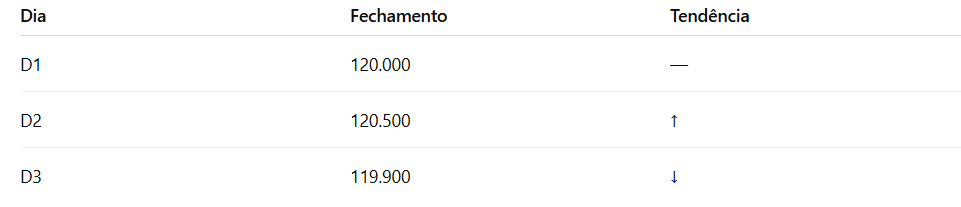

In [2]:
import pandas as pd
import numpy as np
import scipy as stats
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
url = "https://raw.githubusercontent.com/JacksonvBarbosa/Analise_Indice_Ibovespa/refs/heads/Jackson/Dataset/Dados%20Hist%C3%B3ricos%20-%20Ibovespa.csv"

In [16]:
df_ibov = pd.read_csv(url)

# Padronização e limpeza dos dados + análise descritiva e exploratória básica

In [17]:
df_ibov_copia = df_ibov.copy()
df_ibov_copia

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,04.06.2025,137.002,137.547,138.797,136.695,"10,20M","-0,40%"
1,03.06.2025,137.546,136.787,137.672,136.175,"9,70B","0,56%"
2,02.06.2025,136.787,137.026,138.471,136.483,"9,10B","-0,18%"
3,30.05.2025,137.027,138.546,138.637,136.726,"15,14B","-1,09%"
4,29.05.2025,138.534,138.869,139.108,137.993,"8,83B","-0,25%"
...,...,...,...,...,...,...,...
597,10.01.2023,110.817,109.129,111.193,108.478,"13,70M","1,55%"
598,09.01.2023,109.130,108.964,109.938,108.134,"12,05M","0,15%"
599,06.01.2023,108.964,107.642,109.433,107.642,"12,63M","1,23%"
600,05.01.2023,107.641,105.336,107.743,105.333,"15,51M","2,19%"


In [6]:
display(df_ibov_copia.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 602 entries, 0 to 601
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Data      602 non-null    object 
 1   Último    602 non-null    float64
 2   Abertura  602 non-null    float64
 3   Máxima    602 non-null    float64
 4   Mínima    602 non-null    float64
 5   Vol.      602 non-null    object 
 6   Var%      602 non-null    object 
dtypes: float64(4), object(3)
memory usage: 33.1+ KB


None

In [7]:
display(f'Tamanho do dataset: linhas/coluna{df_ibov_copia.shape}')

'Tamanho do dataset: linhas/coluna(602, 7)'

In [8]:
display(df_ibov_copia.describe())

,Último,Abertura,Máxima,Mínima
count,602.000000,602.000000,602.000000,602.000000
mean,122.679924,122.625791,123.474872,121.867294
std,9.312727,9.324912,9.257544,9.368049
min,97.926000,97.926000,99.258000,96.997000
25%,117.068500,117.031250,117.960500,116.177000
50%,125.367500,125.293000,126.206000,124.567000
75%,129.166500,129.125000,129.852250,128.209000
max,140.110000,140.109000,140.382000,138.966000


### Observando as informações dos dados, para melhor manipulação futura devemos converter a coluna **Data** para DateTime e a coluna **Vol.** e **Var%** para Float

1. Qual é a média de fechamento nos ultimos 2 ano?  
* 122 mil pontos  
2. O quanto os pontos estão dispersos da média?  
* mais ou menos 9.3mil pontos
3. Quais foi a mínima e a máxima em pontos que o IBOVESPA alcançou nesses 2 ano?  
* **minima** de 97.926 pontos e uma **máxima** de 140.11 pontos  
4. A mediana está próxima da média de pontos?  
* Sim a **mediana** mais ou menos 3 mil pontos ficando dentro do desvio padrão de fechamentodo indice  


### Uma análise básica exploratória, como uma **mediana** próxima da média nos mostrando que não tivemos umas dispersão significativa vamos ver mais a frente mais da para perceber que não tivemos um outlier nesse periodo

In [9]:
# Varifica dados Nulos
df_ibov_copia.isnull().sum()

Data        0
Último      0
Abertura    0
Máxima      0
Mínima      0
Vol.        0
Var%        0
dtype: int64

In [21]:
# Formatando caracteristica Data e Convertendo em datetime
#df_ibov_copia['Data'] = pd.to_datetime(df_ibov_copia['Data'], format = '%d.%m.%Y').dt.strftime('%d/%m/%Y')
df_ibov_copia['Data'] = pd.to_datetime(df_ibov_copia['Data'], format='%d.%m.%Y')
df_ibov_copia

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,2025-06-04,137.002,137.547,138.797,136.695,"10,20M","-0,40%"
1,2025-06-03,137.546,136.787,137.672,136.175,"9,70B","0,56%"
2,2025-06-02,136.787,137.026,138.471,136.483,"9,10B","-0,18%"
3,2025-05-30,137.027,138.546,138.637,136.726,"15,14B","-1,09%"
4,2025-05-29,138.534,138.869,139.108,137.993,"8,83B","-0,25%"
...,...,...,...,...,...,...,...
597,2023-01-10,110.817,109.129,111.193,108.478,"13,70M","1,55%"
598,2023-01-09,109.130,108.964,109.938,108.134,"12,05M","0,15%"
599,2023-01-06,108.964,107.642,109.433,107.642,"12,63M","1,23%"
600,2023-01-05,107.641,105.336,107.743,105.333,"15,51M","2,19%"


In [22]:
df_ibov_copia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 602 entries, 0 to 601
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Data      602 non-null    datetime64[ns]
 1   Último    602 non-null    float64       
 2   Abertura  602 non-null    float64       
 3   Máxima    602 non-null    float64       
 4   Mínima    602 non-null    float64       
 5   Vol.      602 non-null    object        
 6   Var%      602 non-null    object        
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 33.1+ KB


In [23]:
# Função para conversão dos dados de Volume de string para float
## OBS.: Caso acertando com o grupo e vermos a necessidade de mudar par outro tipo fazer a mudança
def converter_volume(vol):
    if pd.isna(vol):
        return np.nan
    vol = vol.upper().replace(',', '').strip()
    if vol.endswith('B'):
        return float(vol[:-1]) * 1e9
    elif vol.endswith('M'):
        return float(vol[:-1]) * 1e6
    elif vol.endswith('K'):
        return float(vol[:-1]) * 1e3
    else:
        return float(vol)
        
df_ibov_copia['Vol.'] = df_ibov_copia['Vol.'].apply(converter_volume)

In [24]:
df_ibov_copia

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,2025-06-04,137.002,137.547,138.797,136.695,1.020000e+09,"-0,40%"
1,2025-06-03,137.546,136.787,137.672,136.175,9.700000e+11,"0,56%"
2,2025-06-02,136.787,137.026,138.471,136.483,9.100000e+11,"-0,18%"
3,2025-05-30,137.027,138.546,138.637,136.726,1.514000e+12,"-1,09%"
4,2025-05-29,138.534,138.869,139.108,137.993,8.830000e+11,"-0,25%"
...,...,...,...,...,...,...,...
597,2023-01-10,110.817,109.129,111.193,108.478,1.370000e+09,"1,55%"
598,2023-01-09,109.130,108.964,109.938,108.134,1.205000e+09,"0,15%"
599,2023-01-06,108.964,107.642,109.433,107.642,1.263000e+09,"1,23%"
600,2023-01-05,107.641,105.336,107.743,105.333,1.551000e+09,"2,19%"


In [25]:
# Substitui os caracteres (%) por (vázio) e (,) por (.) e converte tipo objeto para float 
df_ibov_copia['Var%'] = df_ibov_copia['Var%'].str.replace('%', '').str.replace(',', '.').astype(float)

In [26]:
print(df_ibov_copia[['Vol.', 'Var%']].dtypes)
print(df_ibov_copia[['Vol.', 'Var%']].head())

Vol.    float64
Var%    float64
dtype: object
           Vol.  Var%
0  1.020000e+09 -0.40
1  9.700000e+11  0.56
2  9.100000e+11 -0.18
3  1.514000e+12 -1.09
4  8.830000e+11 -0.25


# Evoluindo na análise exploratória com gráficos

In [27]:
df_ibov_copia.describe()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
count,602,602.000000,602.000000,602.000000,602.000000,6.020000e+02,602.000000
mean,2024-03-18 23:28:54.219269120,122.679924,122.625791,123.474872,121.867294,1.836857e+11,0.050166
min,2023-01-04 00:00:00,97.926000,97.926000,99.258000,96.997000,4.330000e+08,-3.150000
25%,2023-08-10 06:00:00,117.068500,117.031250,117.960500,116.177000,9.202500e+08,-0.547500
50%,2024-03-20 12:00:00,125.367500,125.293000,126.206000,124.567000,1.110500e+09,0.030000
75%,2024-10-21 18:00:00,129.166500,129.125000,129.852250,128.209000,1.488500e+09,0.650000
max,2025-06-04 00:00:00,140.110000,140.109000,140.382000,138.966000,2.487000e+12,4.290000
std,NaN,9.312727,9.324912,9.257544,9.368049,4.199744e+11,0.966530


Text(0, 0.5, 'Valor em Porcentagem')

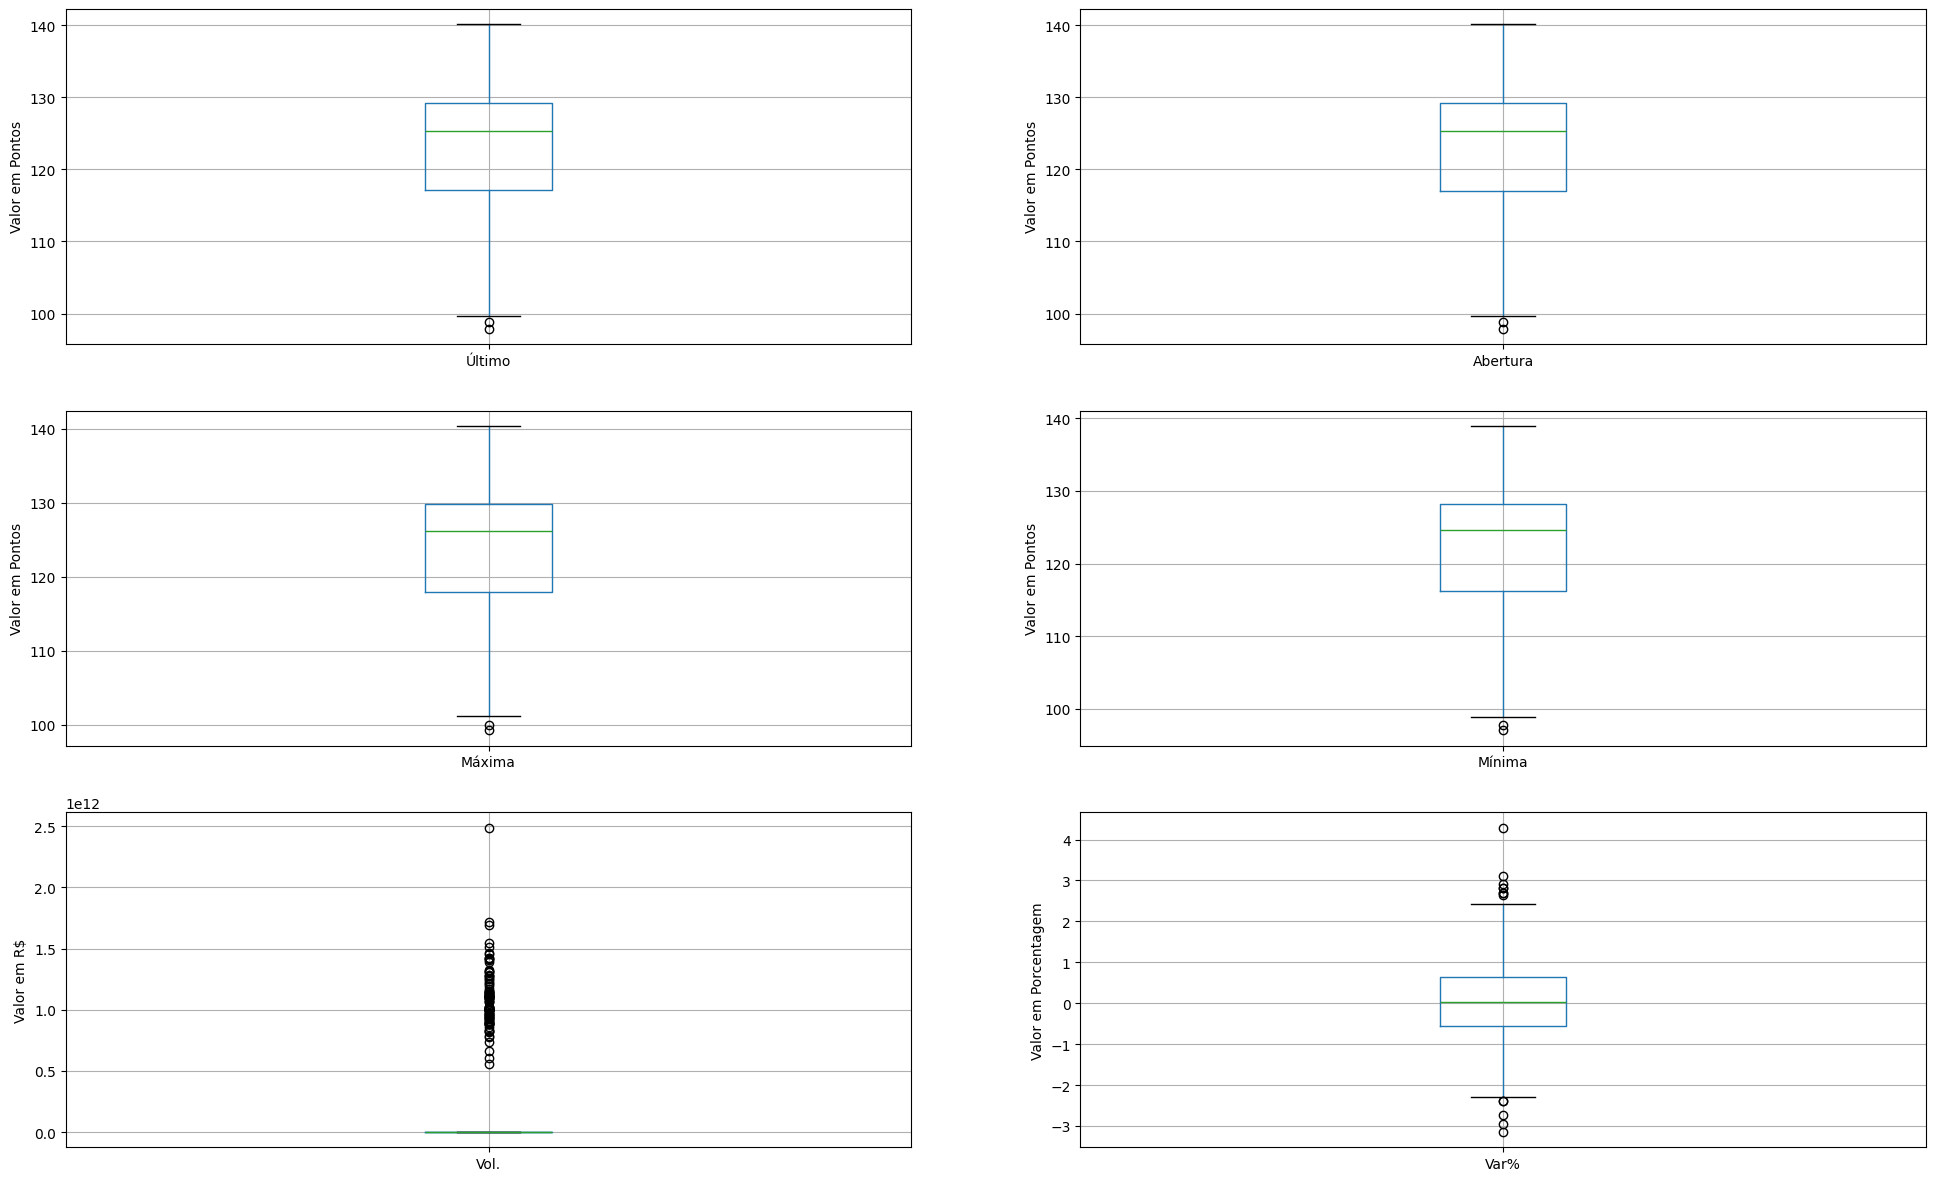

In [31]:
# Avaliando Outliers com Boxplot

plt.figure(figsize=(24,20))

plt.subplot(4, 2, 1) # Parametros -> linhas = 4, colunas = 2, posição = 1(1º gráfico)
fig = df_ibov_copia.boxplot(column='Último')
fig.set_title('')
fig.set_ylabel('Valor em Pontos')

plt.subplot(4, 2, 2) # Parametros -> linhas = 4, colunas = 2, posição = 1(1º gráfico)
fig = df_ibov_copia.boxplot(column='Abertura')
fig.set_title('')
fig.set_ylabel('Valor em Pontos')

plt.subplot(4, 2, 3) # Parametros -> linhas = 4, colunas = 2, posição = 1(1º gráfico)
fig = df_ibov_copia.boxplot(column='Máxima')
fig.set_title('')
fig.set_ylabel('Valor em Pontos')

plt.subplot(4, 2, 4) # Parametros -> linhas = 4, colunas = 2, posição = 1(1º gráfico)
fig = df_ibov_copia.boxplot(column='Mínima')
fig.set_title('')
fig.set_ylabel('Valor em Pontos')

plt.subplot(4, 2, 5) # Parametros -> linhas = 4, colunas = 2, posição = 1(1º gráfico)
fig = df_ibov_copia.boxplot(column='Vol.')
fig.set_title('')
fig.set_ylabel('Valor em R$')

plt.subplot(4, 2, 6) # Parametros -> linhas = 4, colunas = 2, posição = 1(1º gráfico)
fig = df_ibov_copia.boxplot(column='Var%')
fig.set_title('')
fig.set_ylabel('Valor em Porcentagem')

In [60]:
df_ibov_copia['Mes_Ano'] = df_ibov_copia['Data'].dt.to_period('M').astype(str)
df_ibov_copia.sort_values('Mes_Ano')

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%,Mes_Ano
601,2023-01-04,105.334,104.167,105.627,103.915,1.445000e+09,1.12,2023-01
582,2023-01-31,113.431,112.273,113.691,112.145,1.290000e+09,1.03,2023-01
583,2023-01-30,112.273,112.319,112.920,111.824,1.127000e+09,-0.04,2023-01
584,2023-01-27,112.316,114.178,114.191,112.044,1.061000e+09,-1.63,2023-01
585,2023-01-26,114.178,114.271,114.835,113.591,1.092000e+09,-0.08,2023-01
...,...,...,...,...,...,...,...,...
23,2025-05-02,135.134,135.067,135.275,134.355,1.274000e+12,0.05,2025-05
13,2025-05-16,139.187,139.335,139.335,137.713,1.211000e+12,-0.11,2025-05
2,2025-06-02,136.787,137.026,138.471,136.483,9.100000e+11,-0.18,2025-06
1,2025-06-03,137.546,136.787,137.672,136.175,9.700000e+11,0.56,2025-06


In [63]:
df_ibov_copia.iloc[160:, :]

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%,Mes_Ano
160,2024-10-08,131.512,132.016,132.016,130.371,9.090000e+08,-0.38,2024-10
161,2024-10-07,132.018,131.792,132.943,131.676,7.700000e+08,0.17,2024-10
162,2024-10-04,131.792,131.672,131.936,131.156,7.050000e+08,0.09,2024-10
163,2024-10-03,131.672,133.514,133.514,131.176,9.820000e+08,-1.38,2024-10
164,2024-10-02,133.515,132.495,134.922,132.495,9.400000e+08,0.77,2024-10
...,...,...,...,...,...,...,...,...
597,2023-01-10,110.817,109.129,111.193,108.478,1.370000e+09,1.55,2023-01
598,2023-01-09,109.130,108.964,109.938,108.134,1.205000e+09,0.15,2023-01
599,2023-01-06,108.964,107.642,109.433,107.642,1.263000e+09,1.23,2023-01
600,2023-01-05,107.641,105.336,107.743,105.333,1.551000e+09,2.19,2023-01


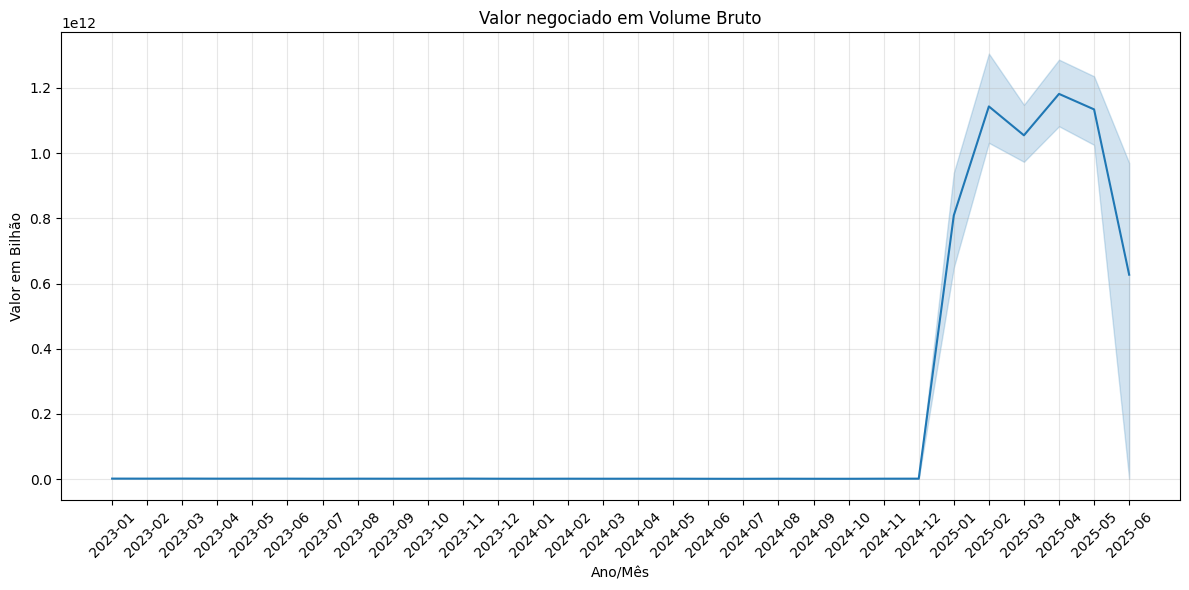

In [67]:
# Observando volume negociado Vol.

plt.figure(figsize=(12,6))
sns.lineplot(data=df_ibov_copia.sort_values('Mes_Ano'), x='Mes_Ano', y='Vol.', markers='o')
plt.title('Valor negociado em Volume Bruto')
plt.xlabel('Ano/Mês')
plt.ylabel('Valor em Bilhão')
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

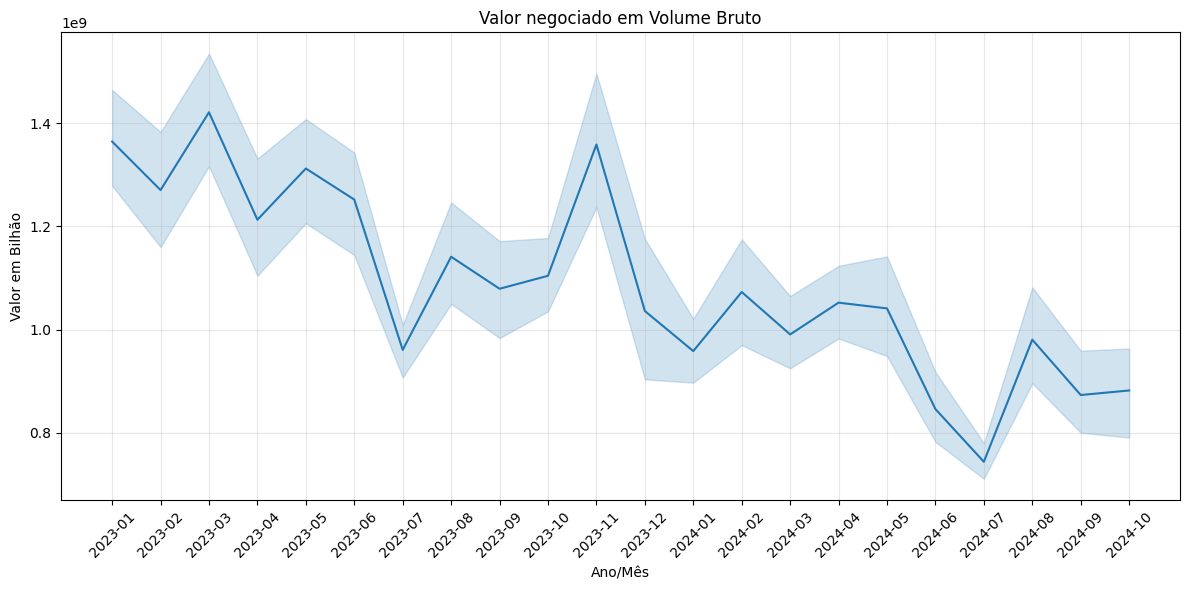

In [66]:
# Observando volume negociado Vol Retirando as negociações a partir de 11/2024.

plt.figure(figsize=(12,6))
sns.lineplot(data=df_ibov_copia.iloc[160:, :].sort_values('Mes_Ano'), x='Mes_Ano', y='Vol.', markers='o')
plt.title('Valor negociado em Volume Bruto')
plt.xlabel('Ano/Mês')
plt.ylabel('Valor em Bilhão')
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Aqui podemos observar um volume de negociação muito grande no periodo do final do ano de 2024 até o final do segundo trimestre de 2025.

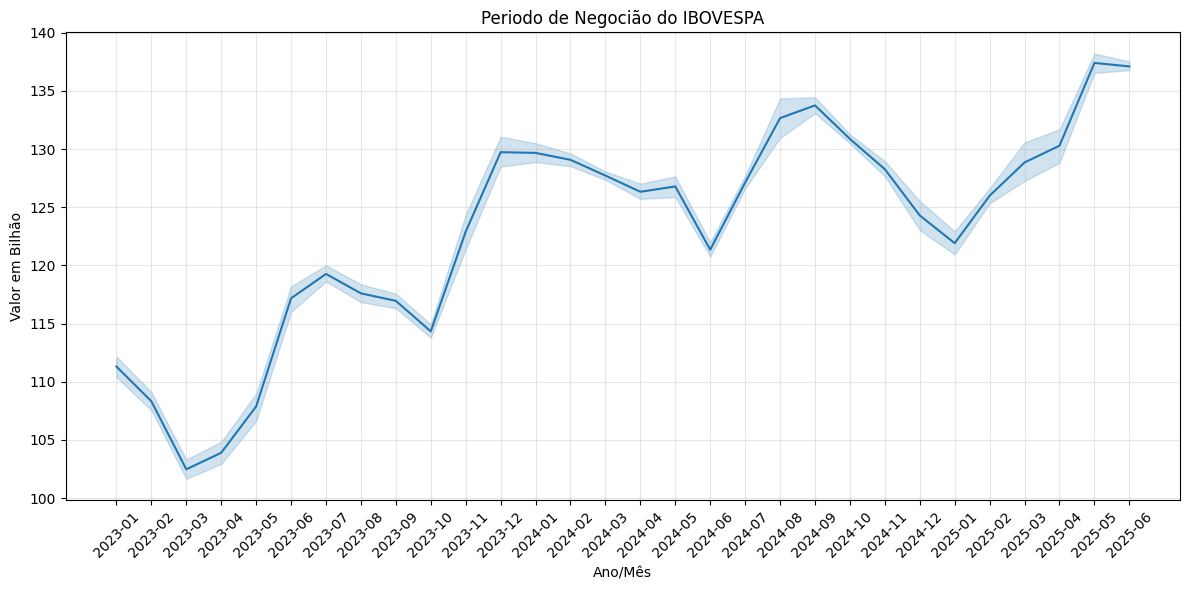

In [43]:
# Observando Negociação do IBOVESPA.

plt.figure(figsize=(12,6))
sns.lineplot(data=df_ibov_copia.sort_values('Mes_Ano'), x='Mes_Ano', y='Último', markers='o')
plt.title('Periodo de Negociação do IBOVESPA')
plt.xlabel('Ano/Mês')
plt.ylabel('Pontos')
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

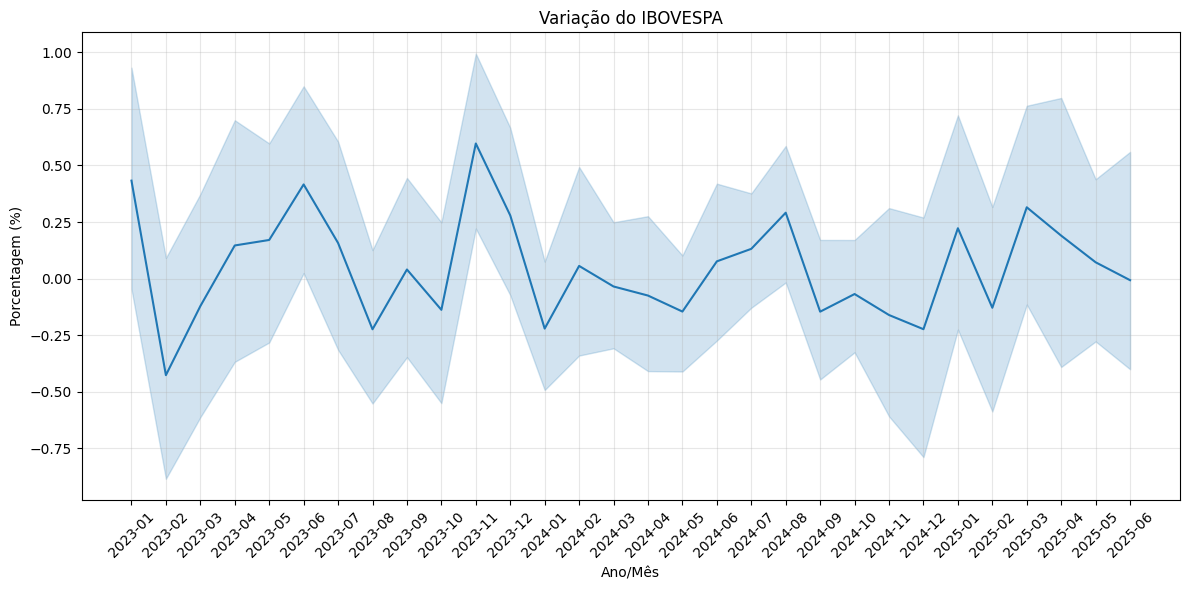

In [45]:
# Observando Variação do IBOVESPA.

plt.figure(figsize=(12,6))
sns.lineplot(data=df_ibov_copia.sort_values('Mes_Ano'), x='Mes_Ano', y='Var%', markers='o')
plt.title('Variação do IBOVESPA')
plt.xlabel('Ano/Mês')
plt.ylabel('Porcentagem (%)')
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Criar uma caracteristica (coluna) de fechamento positivo(1) ou negativo(0) utilizando a caracteristica [Último] como referência

In [10]:
'''Exemplo do metodo Shift ele irá varrer o data frame e conforme o parametro colocado nele ele irá fazer o deslocamento
para linha seguinte ou anterior
Ex.: Shift(n) -> Compara valores anteriores (n>0)
     Shift(n) -> Compara valores seguintes (n<0) Vamos usar este para buscar valores seguintes
     Shift(n) -> Compara com o dia anterior (n=1)

''' 
# Exemplos de uso
df = pd.DataFrame({'Preço': [100, 102, 101, 105]})
df['Anterior'] = df['Preço'].shift(1)
df['Seguinte'] = df['Preço'].shift(-1)

df

## Não tem a necessidade de Rodar esse código

,Preço,Anterior,Seguinte
0,100,NaN,102.0
1,102,100.0,101.0
2,101,102.0,105.0
3,105,101.0,NaN


In [11]:
# Caso quisermos utilizar o loop for

'''fechamento = df_ibov['Último'].values
fechamento_categoria = []

for i in range(len(fechamento) - 1):
    if fechamento[i + 1] > fechamento[i]:
        fechamento_categoria.append(1)
    else:
        fechamento_categoria.append(0)

# Como comparamos até o penúltimo, o último dia não tem "dia seguinte"
fechamento_categoria.append(None)  # ou np.nan se preferir

# Adiciona a nova coluna no DataFrame
#df_ibov['Subiu_dia_seguinte'] = fechamento_categoria

print(fechamento_categoria)'''

'fechamento = df_ibov[\'Último\'].values\nfechamento_categoria = []\n\nfor i in range(len(fechamento) - 1):\n    if fechamento[i + 1] > fechamento[i]:\n        fechamento_categoria.append(1)\n    else:\n        fechamento_categoria.append(0)\n\n# Como comparamos até o penúltimo, o último dia não tem "dia seguinte"\nfechamento_categoria.append(None)  # ou np.nan se preferir\n\n# Adiciona a nova coluna no DataFrame\n#df_ibov[\'Subiu_dia_seguinte\'] = fechamento_categoria\n\nprint(fechamento_categoria)'

In [12]:
# Renomeando nome da Coluna Último para Fechamento_Diario
df_ibov_copia = df_ibov_copia.rename(columns={"Último": "Fechamento_Diario"})

In [13]:
# Cria a coluna fechamento com valores Binarios 0 para negativo e 1 para positivo
df_ibov_copia['Tendencia'] = (df_ibov['Último'].shift(-1) > df_ibov['Último']).astype('Int64')

In [14]:
# Setando data como indice ()index
df_ibov_copia = df_ibov_copia.set_index('Data')
df_ibov_copia

,Fechamento_Diario,Abertura,Máxima,Mínima,Vol.,Var%,Tendencia
Data,,,,,,,
2025-06-04,137.002,137.547,138.797,136.695,1.020000e+09,-0.40,1
2025-06-03,137.546,136.787,137.672,136.175,9.700000e+11,0.56,0
2025-06-02,136.787,137.026,138.471,136.483,9.100000e+11,-0.18,1
2025-05-30,137.027,138.546,138.637,136.726,1.514000e+12,-1.09,1
2025-05-29,138.534,138.869,139.108,137.993,8.830000e+11,-0.25,1
...,...,...,...,...,...,...,...
2023-01-10,110.817,109.129,111.193,108.478,1.370000e+09,1.55,0
2023-01-09,109.130,108.964,109.938,108.134,1.205000e+09,0.15,0
2023-01-06,108.964,107.642,109.433,107.642,1.263000e+09,1.23,0


In [15]:
# Existe dados Nulos
df_ibov_copia.isnull().sum()

Fechamento_Diario    0
Abertura             0
Máxima               0
Mínima               0
Vol.                 0
Var%                 0
Tendencia            0
dtype: int64

In [16]:
# Inicio e fim do ano de extraidos do dataset
print(f'Data Inicial: {df_ibov_copia.index.min()}')
print(f'Data Inicial: {df_ibov_copia.index.max()}')

Data Inicial: 2023-01-04 00:00:00
Data Inicial: 2025-06-04 00:00:00


In [17]:
# Temos dados duplicados
df_ibov_copia.duplicated().sum()

np.int64(0)

O %b é um código de formatação de datas que representa o nome abreviado do mês, como:

Código	Resultado Exemplo  
%b	Jan, Feb, Mar...  
%B	January, February, March... (nome completo do mês)  
%m	01, 02, 03... (número do mês com dois dígitos)  
%Y	2025 (ano com quatro dígitos)  
%y	25 (ano com dois dígitos)  

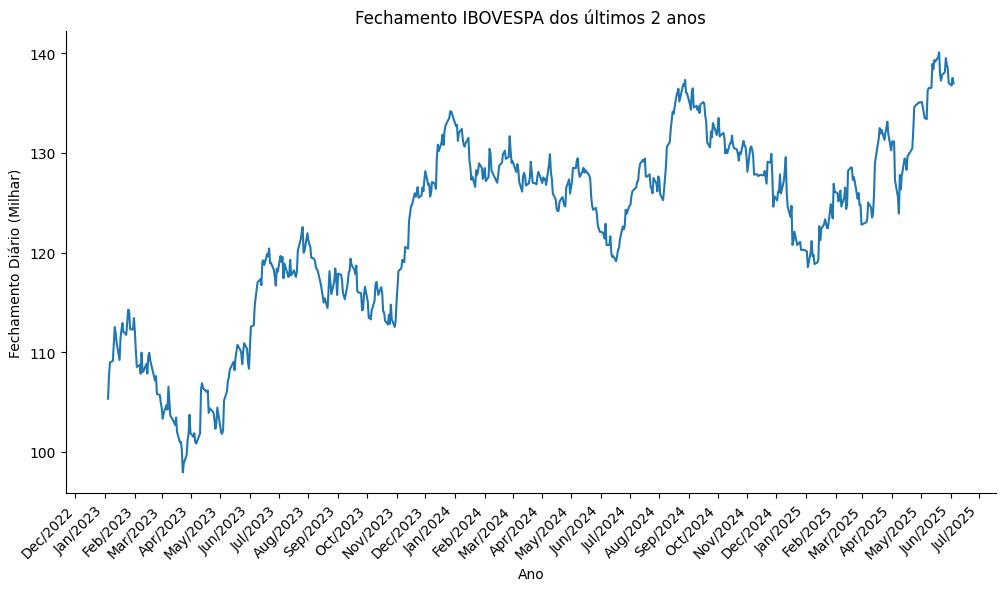

In [18]:
import matplotlib.dates as mdates

# Gráfico de linha
fig, axes = plt.subplots(figsize=(12,6))

sns.lineplot(data=df_ibov_copia, x=df_ibov_copia.index, y='Fechamento_Diario', ax=axes)

# Formatação do eixo X para mostrar um rótulo por mês
axes.xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Um tick por mês %b	Jan, Feb, Mar...
axes.xaxis.set_major_formatter(mdates.DateFormatter('%b/%Y'))  # Exibe como Jan/2024

# Rotaciona os rótulos para melhor visualização
plt.setp(axes.get_xticklabels(), rotation=45, ha='right')

axes.set_xlabel('Ano')
axes.set_ylabel('Fechamento Diário (Milhar)')
axes.set_title('Fechamento IBOVESPA dos últimos 2 anos')
sns.despine()
plt.show()

### **O gráfico de linha em ralação ao tempo nos mostra que o IBOVESPA vem am uma tendência de alta rompendo topos atrás de todos**

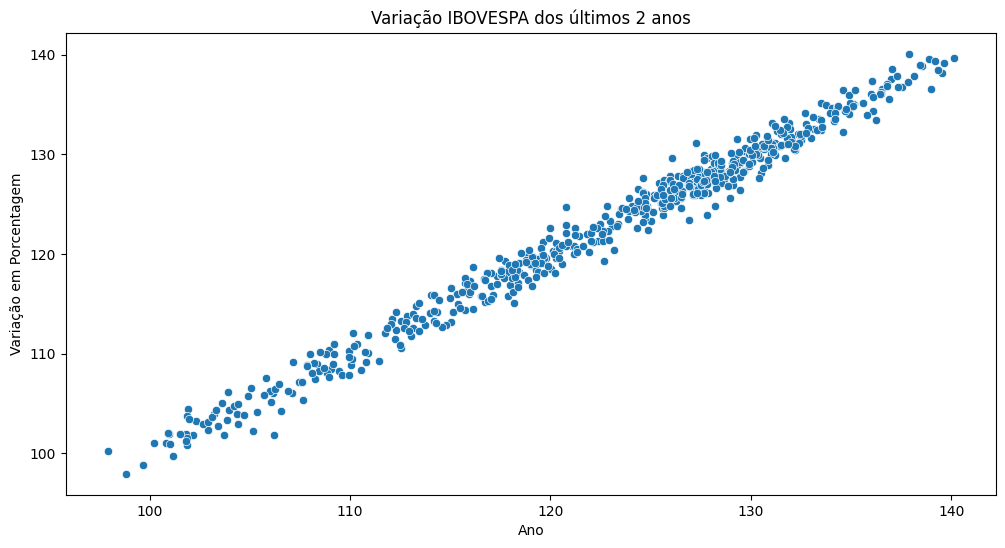

In [35]:
import matplotlib.dates as mdates

# Gráfico de de Dispersão
fig, axes = plt.subplots(figsize=(12,6))

sns.scatterplot(data=df_ibov_copia, x="Fechamento_Diario", y='Abertura', ax=axes)

# Rotaciona os rótulos para melhor visualização
#plt.setp(axes.get_xticklabels(), rotation=45, ha='right')

axes.set_xlabel('Ano')
axes.set_ylabel('Variação em Porcentagem')
axes.set_title('Variação IBOVESPA dos últimos 2 anos')
plt.show()

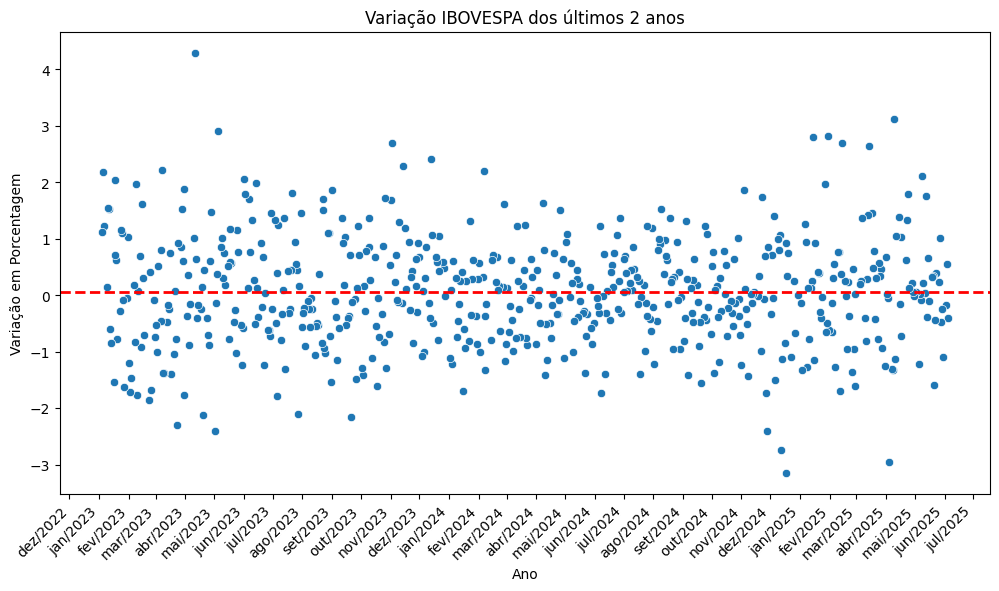

In [23]:
import matplotlib.dates as mdates

# Gráfico de de Dispersão
fig, axes = plt.subplots(figsize=(12,6))

sns.scatterplot(data=df_ibov_copia, x=df_ibov_copia.index, y='Var%', ax=axes)

# Linha horizontal na média da variação
media = df_ibov_copia['Var%'].mean()
axes.axhline(media, color='red', linestyle='--', linewidth=2, label=f'Média ({media:.2f}%)')

# Formatação do eixo X para mostrar um rótulo por mês
axes.xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Um tick por mês %b	Jan, Feb, Mar...
axes.xaxis.set_major_formatter(mdates.DateFormatter('%b/%Y'))  # Exibe como Jan/2024

# Rotaciona os rótulos para melhor visualização
plt.setp(axes.get_xticklabels(), rotation=45, ha='right')

axes.set_xlabel('Ano')
axes.set_ylabel('Variação em Porcentagem')
axes.set_title('Variação IBOVESPA dos últimos 2 anos')
plt.show()

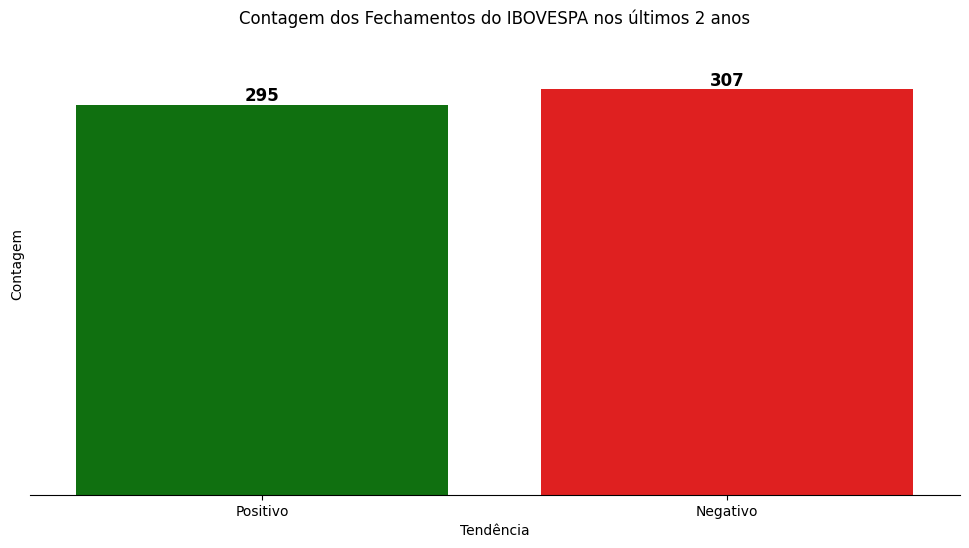

In [20]:
# Quantidade de dias que o IBOVESPA teve o fechamento Positivo e Negativo

# Substitui 0 por 'Negativo' e 1 por 'Positivo'
df_temp = df_ibov_copia.copy()
df_temp['Tendencia'] = df_temp['Tendencia'].map({0: 'Negativo', 1: 'Positivo'})

# Define as cores desejadas para cada categoria
palette_cores = {'Negativo': 'red', 'Positivo': 'green'}

# Gráfico de barra
fig, axes = plt.subplots(figsize=(12,6))

sns.countplot(data=df_temp, x='Tendencia', hue='Tendencia', ax=axes, palette=palette_cores, legend=False)

# Adiciona os labels (valores) nas barras
for p in axes.patches:
    altura = p.get_height()
    axes.annotate(f'{int(altura)}',  # texto (valor da barra)
                  (p.get_x() + p.get_width() / 2, altura),  # posição do texto
                  ha='center', va='bottom', fontsize=12, fontweight='bold')

# Remove os números do eixo Y
axes.set_yticks([])

axes.set_xlabel('Tendência')
axes.set_ylabel('Contagem')
axes.set_ylim(0, 350)
axes.set_title('Contagem dos Fechamentos do IBOVESPA nos últimos 2 anos')
sns.despine(left=True)
plt.show()

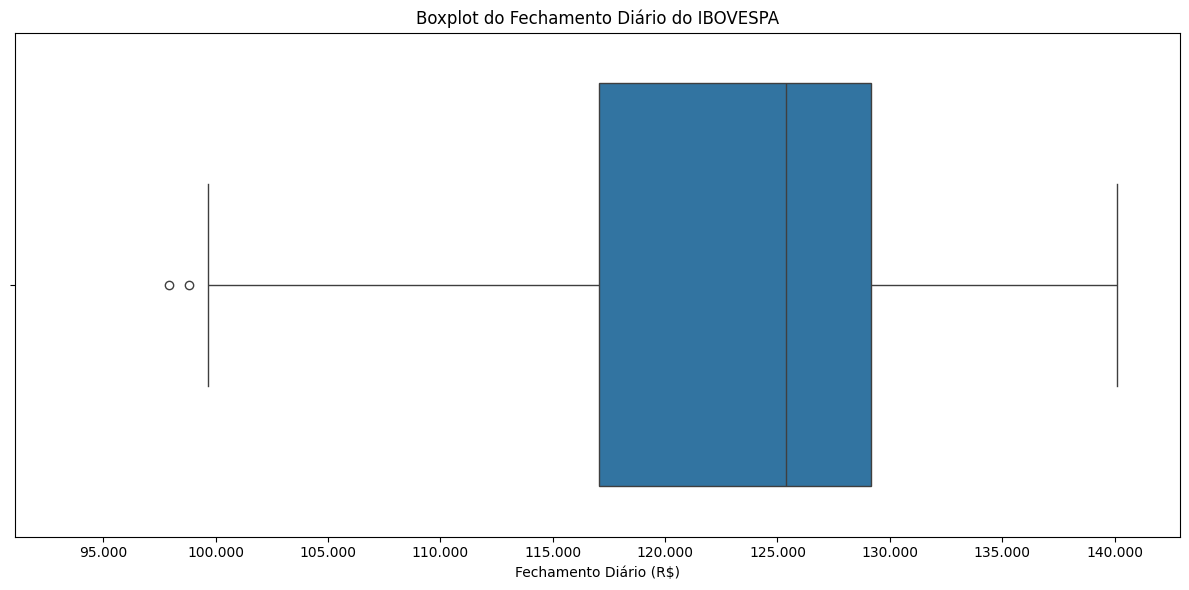

In [21]:
from matplotlib.ticker import FuncFormatter, MultipleLocator

# Copia e ajusta os dados
df_temp_fech = df_ibov_copia.copy()
df_temp_fech["Fechamento_Diario"] = df_temp_fech["Fechamento_Diario"] * 1000

# Criação do gráfico
fig, axes = plt.subplots(figsize=(12,6))
sns.boxplot(data=df_temp_fech, x="Fechamento_Diario", ax=axes)

# Valores mínimo e máximo
min_val = df_temp_fech['Fechamento_Diario'].min() - 5000
max_val = df_temp_fech['Fechamento_Diario'].max()

# Limites com margem de 2%
axes.set_xlim(min_val * 0.98, max_val * 1.02)

# Ticks de 5.000 em 5.000
axes.xaxis.set_major_locator(MultipleLocator(5000))

# Formata para exibir separador de milhar
formatter = FuncFormatter(lambda x, _: f'{int(x):,}'.replace(',', '.')) # _: o segundo argumento é exigido pelo FuncFormatter, mas não precisamos dele aqui (por isso usamos _ como convenção de "ignorado").
axes.xaxis.set_major_formatter(formatter)

# Estética
axes.set_xlabel('Fechamento Diário (R$)')
axes.set_title('Boxplot do Fechamento Diário do IBOVESPA')
plt.tight_layout()
plt.show()